In [34]:
import pandas as pd 
from scipy.stats import spearmanr
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Extracting PIF & SUDA score across all datasets for rows. 

In [51]:
def collect_scores(base_dir, input_word, score_field, pif_index_col='Unnamed: 0'):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().startswith(input_word) and file.lower().endswith(".csv"):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(os.path.dirname(file_path))

                try:
                    # Read the file
                    df = pd.read_csv(file_path)

                    if input_word.lower() == 'pif':
                        # For PIF files, use 'Unnamed: 0' as the original index
                        if pif_index_col in df.columns and score_field in df.columns:
                            temp_df = df[[score_field]].copy()
                            temp_df['original_index'] = df[pif_index_col]
                            temp_df['file_name'] = file
                            temp_df['folder_name'] = folder_name
                            all_data.append(temp_df)
                    elif input_word.lower() == 'suda':
                        # For SUDA files, use the DataFrame's default index
                        if score_field in df.columns:
                            temp_df = df[[score_field]].copy()
                            temp_df['original_index'] = df.index
                            temp_df['file_name'] = file
                            temp_df['folder_name'] = folder_name
                            all_data.append(temp_df)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

    if all_data:
        result_df = pd.concat(all_data, ignore_index=True)
        return result_df
    else:
        return pd.DataFrame(columns=[score_field, 'original_index', 'file_name', 'folder_name'])

# Specify the base directory
base_directory = os.getcwd()

# Collect scores for 'suda' datasets
result_suda = collect_scores(base_directory, 'suda', 'dis-score')

# Collect scores for 'pif' datasets
result_pif = collect_scores(base_directory, 'pif', 'RIG')
result_pif = result_pif.sort_values(by=['file_name', 'original_index'], ascending=[True, True])


Merged DataFrame:
Global Spearman Correlation: 0.7795, P-value: 0.0000


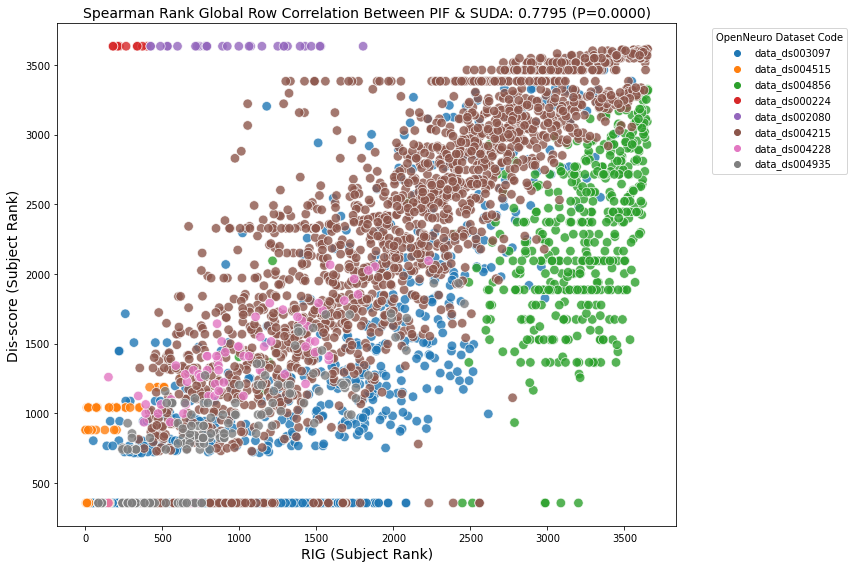

In [52]:
merged = pd.merge(result_pif, result_suda, on=['original_index', 'folder_name'], suffixes=('_pif', '_suda'))
if merged.empty:
    print("The merged DataFrame is empty. Check file names and original index alignment.")
else:
    print("Merged DataFrame:")

    merged['RIG_rank'] = merged['RIG'].rank()
    merged['dis_score_rank'] = merged['dis-score'].rank()
    spearman_corr, p_value = spearmanr(merged['RIG'], merged['dis-score'])

    print(f"Global Spearman Correlation: {spearman_corr:.4f}, P-value: {p_value:.4f}")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=merged, 
        x='RIG_rank',        
        y='dis_score_rank',  
        hue='folder_name',   
        palette='tab10',
        s=90,
        alpha=0.8
    )

    plt.title(f"Spearman Rank Global Row Correlation Between PIF & SUDA: {spearman_corr:.4f} (P={p_value:.4f})", fontsize=14)
    plt.xlabel('RIG (Subject Rank)', fontsize=14)
    plt.ylabel('Dis-score (Subject Rank)', fontsize=14)
    plt.legend(title='OpenNeuro Dataset Code', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('spearman_rank_correlation_plot.png', dpi=300)
    plt.show()

## Extracting K-Global, SUDA & PIF score across all datasets for fields. 

In [3]:
def extract_att_suda_files(base_dir):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower() == 'att_suda.csv':
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(root)
                
                try:
                    df = pd.read_csv(file_path)
                    if 'variable' in df.columns and 'contribution' in df.columns:
                        temp_df = df[['variable', 'contribution']].copy()
                        temp_df['folder_name'] = folder_name
                        temp_df['file_name'] = file
                        all_data.append(temp_df)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
    
    if all_data:
        result_df = pd.concat(all_data, ignore_index=True)
        return result_df
    else:
        return pd.DataFrame(columns=['variable', 'contribution', 'folder_name', 'file_name'])

base_directory = os.getcwd()
result_suda_fields = extract_att_suda_files(base_directory)



In [31]:
def extract_normalized_files(base_dir):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().startswith('normalized') and file.lower().endswith('.csv'):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(root)
                try:
                    df = pd.read_csv(file_path)
                    if 'Column' in df.columns and 'Normalized Difference' in df.columns:
                        temp_df = df[['Column', 'Normalized Difference']].copy()
                        temp_df['folder_name'] = folder_name
                        temp_df['file_name'] = file
                        all_data.append(temp_df)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame(columns=['Column', 'Normalized Difference', 'folder_name', 'file_name'])

base_directory = os.getcwd()
result_k_global = extract_normalized_files(base_directory)





## Correlation spearman rank K-Global & SUDA


Global Spearman Correlation: -0.0957, P-value: 0.5178


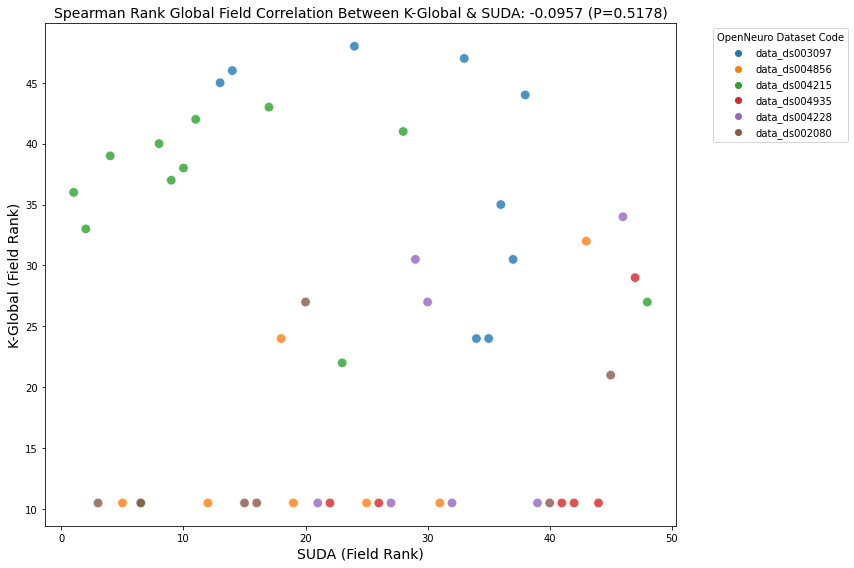

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr



# Convert dictionaries to DataFrames
result_k_global = pd.DataFrame(result_k_global)
result_suda = pd.DataFrame(result_suda_fields)

# Merge the datasets on Column/variable and folder_name
merged = pd.merge(
    result_k_global, 
    result_suda, 
    left_on=["Column", "folder_name"], 
    right_on=["variable", "folder_name"], 
    
)


merged['k_global_rank'] = merged['Normalized Difference'].rank()
merged['suda_field_rank'] = merged['contribution'].rank()
spearman_corr, p_value = spearmanr(merged['Normalized Difference'], merged['contribution'])

print(f"Global Spearman Correlation: {spearman_corr:.4f}, P-value: {p_value:.4f}")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=merged, 
    x='suda_field_rank',        
    y='k_global_rank',  
    hue='folder_name',   
    palette='tab10',
    s=90,
    alpha=0.8
)

plt.title(f"Spearman Rank Global Field Correlation Between K-Global & SUDA: {spearman_corr:.4f} (P={p_value:.4f})", fontsize=14)
plt.xlabel('SUDA (Field Rank)', fontsize=14)
plt.ylabel('K-Global (Field Rank)', fontsize=14)
plt.legend(title='OpenNeuro Dataset Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('spearman_rank_correlation_plot_k_global_suda_field.png', dpi=300)
plt.show()

## Get PIF Field scores (FIG)

In [125]:
def extract_and_sum_pif_files_with_column_names(base_dir):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().startswith('pif') and file.lower().endswith('.csv'):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(root)
                try:
                    df = pd.read_csv(file_path)
                    if 'RIG' in df.columns:
                        df = df.drop(columns=['RIG','Unnamed: 0'])
                    sum_scores = df.sum()/len(df)
                    for col_name, col_sum in sum_scores.items():
                        all_data.append({'folder_name': folder_name, 'column_name': col_name, 'sum_score': col_sum})
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
    return pd.DataFrame(all_data)


base_directory = os.getcwd()
result_pif_fields = extract_and_sum_pif_files_with_column_names(base_directory)

result_suda_fields = result_suda_fields.rename(columns={"variable": "column_name"})
merged = pd.merge(
    result_pif_fields,
    result_suda_fields,
    on=["folder_name", "column_name"],
    how="inner",
    indicator=False
)

merged = merged[~merged['folder_name'].isin(['data_ds000224', 'data_ds004515'])]
merged = merged[~merged['column_name'].isin(['Weight_W1', 'BMI_W1','religious_upbringing','religious_now'])]


merged['PIF_rank_field'] = merged['sum_score'].rank()
merged['suda_field_rank'] = merged['contribution'].rank()

## Correlation spearman rank PIF & SUDA

Global Spearman Correlation: 0.67, P-value: 0.00


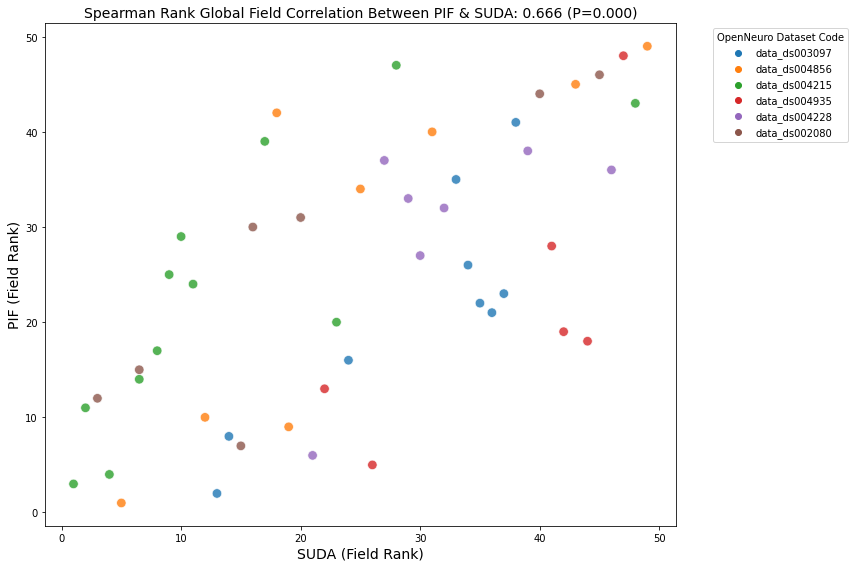

In [126]:
merged['PIF_rank_field'] = merged['sum_score'].rank()
merged['suda_field_rank'] = merged['contribution'].rank()
spearman_corr, p_value = spearmanr(merged['sum_score'], merged['contribution'])

print(f"Global Spearman Correlation: {spearman_corr:.2f}, P-value: {p_value:.2f}")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=merged, 
    x='suda_field_rank',        
    y='PIF_rank_field',  
    hue='folder_name',   
    palette='tab10',
    s=90,
    alpha=0.8
)

plt.title(f"Spearman Rank Global Field Correlation Between PIF & SUDA: {spearman_corr:.3f} (P={p_value:.3f})", fontsize=14)
plt.xlabel('SUDA (Field Rank)', fontsize=14)
plt.ylabel('PIF (Field Rank)', fontsize=14)
plt.legend(title='OpenNeuro Dataset Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('spearman_rank_correlation_plot_pif_suda_field.png', dpi=300)
plt.show()

## Correlation spearman rank PIF & k-Global

Global Spearman Correlation: 0.104, P-value: 0.480


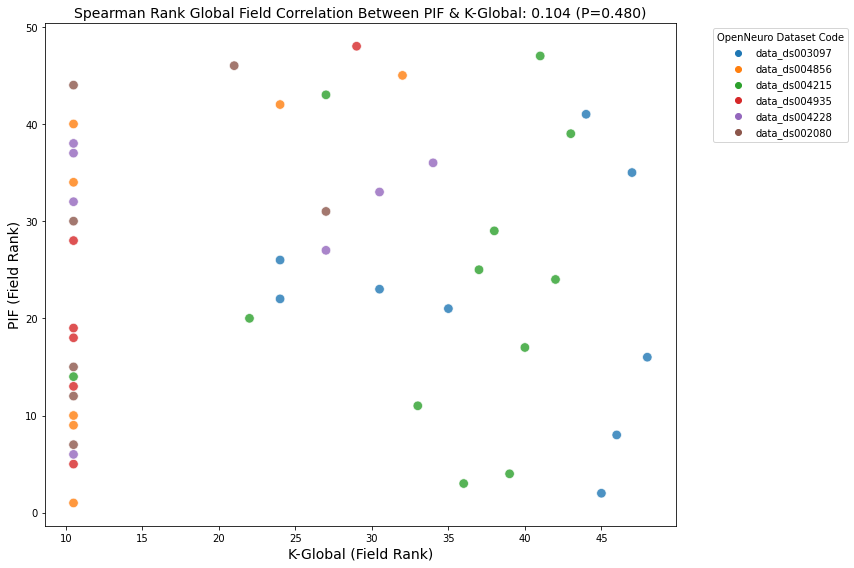

In [130]:
result_k_global = result_k_global.rename(columns={"Column": "column_name"})


merged_result = pd.merge(
    result_k_global,
    result_pif_fields,
    on=["column_name", "folder_name"],
    how="inner"
)
merged_result

merged_result['PIF_rank_field'] = merged_result['sum_score'].rank()
merged_result['k_field_rank'] = merged_result['Normalized Difference'].rank()
spearman_corr, p_value = spearmanr(merged_result['Normalized Difference'], merged_result['sum_score'])


print(f"Global Spearman Correlation: {spearman_corr:.3f}, P-value: {p_value:.3f}")
plt.figure(figsize=(12, 8))


sns.scatterplot(
    data=merged_result, 
    x='k_field_rank',        
    y='PIF_rank_field',  
    hue='folder_name',   
    palette='tab10',
    s=90,
    alpha=0.8
)

plt.title(f"Spearman Rank Global Field Correlation Between PIF & K-Global: {spearman_corr:.3f} (P={p_value:.3f})", fontsize=14)
plt.xlabel('K-Global (Field Rank)', fontsize=14)
plt.ylabel('PIF (Field Rank)', fontsize=14)
plt.legend(title='OpenNeuro Dataset Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('spearman_rank_correlation_plot_pif_k_global_field.png', dpi=300)
plt.show()